In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import xarray as xr

In [2]:
# - Set data path
dpath = '/opt/acoustic-variability/data/'

In [3]:
# - Set saved out figure path
figpath = '/opt/acoustic-variability/python/figures/'

# Compile JASADCP metadata

### Read JASADCP metadata into csv

In [153]:
fnames = os.listdir(dpath + 'JASADCP/ncfiles')
#os.listdir(dpath + 'TAO_NDBC/ncfiles')

In [154]:
nc_counter = len(glob.glob1(dpath + 'JASADCP/ncfiles',"*.nc"))
hardware_model = [None]*nc_counter
serial_numbers = [None]*nc_counter
transmit_frequency = [None]*nc_counter
phased_array = [None]*nc_counter
cruise_beg_date = [None]*nc_counter
blanking_interval = [None]*nc_counter
bin_length = [None]*nc_counter
transducer_beam_angle = [None]*nc_counter
transmit_pulse_length = [None]*nc_counter
comments = [None]*nc_counter
biomass_dtmn = [None]*nc_counter

In [155]:
ifile = 0
for fname in os.listdir(dpath + 'JASADCP/ncfiles/'):
    ncfile = dpath + 'JASADCP/ncfiles/' + fname
    ncnow = xr.open_dataset(ncfile)
    strnow = ncnow.attrs['cruise_sonar_summary']
    # 1.) hardware_model
    hardware_modelnow = re.findall("HARDWARE MODEL *: *((?:\S+ )*\S+)", strnow)
    if hardware_modelnow:
        hardware_model[ifile] = hardware_modelnow[0]
    elif not hardware_modelnow: # if hardware_modelnow is empty
        manufacturernow = re.findall("MANUFACTURER *: *((?:\S+ )*\S+)", strnow)
        if manufacturernow:
            hardware_model[ifile] = manufacturernow[0]
    # 2.) serial_numbers
    serial_numbersnow = re.findall("SERIAL NUMBERS *: *((?:\S+ )*\S+)", strnow)
    if serial_numbersnow:
        serial_numbers[ifile] = serial_numbersnow[0]
    # 3.) transmit_frequency
    transmit_frequencynow = re.findall("TRANSMIT FREQUENCY *: *((?:\S+ )*\S+)", strnow)
    if transmit_frequencynow:
        transmit_frequency[ifile] = transmit_frequencynow[0]
    # 4.) phased_array 
    phased_arraynow = re.findall("phased.array", strnow, re.IGNORECASE)
    if phased_arraynow:
        sep = '///'; phased_arraynow = sep.join(phased_arraynow)
        phased_array[ifile] = phased_arraynow
    # 5.) cruise_beg_date
    cruise_beg_date[ifile] = ncnow['time'][0].values
    # 6.) blanking_interval
    blanking_intervalnow = re.findall("BLANKING INTERVAL *: *((?:\S+ )*\S+)", strnow)
    if blanking_intervalnow:
        blanking_interval[ifile] = blanking_intervalnow[0]
    # 7.) bin_length
    bin_lengthnow = re.findall("BIN LENGTH *: *((?:\S+ )*\S+)", strnow)
    if bin_lengthnow:
        bin_length[ifile] = bin_lengthnow[0]
    # 8.) transducer_beam_angle
    transducer_beam_anglenow = re.findall("TRANSDUCER BEAM ANGLE *: *((?:\S+ )*\S+)", strnow)
    if transducer_beam_anglenow:
        transducer_beam_angle[ifile] = transducer_beam_anglenow[0]
    # 9.) transmit_pulse_length
    transmit_pulse_lengthnow = re.findall("TRANSMIT PULSE LENGTH *: *((?:\S+ )*\S+)", strnow)
    if transmit_pulse_lengthnow:
        transmit_pulse_length[ifile] = transmit_pulse_lengthnow[0]
    # 10.) comments
    commentsnow = re.findall("COMMENTS *: *((?:\S+ )*\S+)", strnow)
    if commentsnow:
        sep = '///'; commentsnow = sep.join(commentsnow)
        comments[ifile] = commentsnow
    # 11.) biomass_dtmn
    biomass_dtmnnow = re.findall("BIOMASS DETERMINATION *: *((?:\S+ )*\S+)", strnow)
    if biomass_dtmnnow:
        biomass_dtmn[ifile] = biomass_dtmnnow[0]
    ifile = ifile+1

In [156]:
df = pd.concat(
    [pd.Series(hardware_model,name='hardware_model'), pd.Series(serial_numbers,name='serial_numbers'),
     pd.Series(transmit_frequency,name='transmit_frequency'),pd.Series(phased_array,name='phased_array'),
     pd.Series(cruise_beg_date,name='cruise_beg_date'),pd.Series(blanking_interval,name='blanking_interval'),
     pd.Series(bin_length,name='bin_length'),pd.Series(transducer_beam_angle,name='transducer_beam_angle'),
     pd.Series(transmit_pulse_length,name='transmit_pulse_length'),pd.Series(comments,name='comments')],
     axis=1)

In [157]:
# - Define fxns to describe bandwidth from comments and hardware_model

# --> Checks for hardware_model names containing NB = narrowband
#dfnow = df.dropna(subset=['hardware_model'])
#dfnow[dfnow['hardware_model'].str.contains('NB')]['hardware_model'].unique()
# --> Results are:
# array(['NB 150 (VM-150-18HP)', 'NB 150', 'VM-150 (NB)'], dtype=object)

def set_bandwidth_from_comments(row):
    if row['comments']:
        if (re.search('broad', row['comments'], re.IGNORECASE) and
                re.search('narro', row['comments'], re.IGNORECASE)):
            return 'both broad and narrow?' 
        elif (re.search('broad', row['comments'], re.IGNORECASE) and
                re.search('phased.array', row['comments'], re.IGNORECASE)):
            return 'both broad and phased.array?' 
        elif re.search('broad', row['comments'], re.IGNORECASE):
            return 'broad'
        elif (re.search('narro', row['comments'], re.IGNORECASE) or
                re.search('phased.array', row['comments'], re.IGNORECASE)): 
            return 'narrow'
        else:
            return 'unknown'
    else:
        return 'unknown'

def set_bandwidth_from_hardware_model(row):
    if row['hardware_model']:
        if re.search('broad', row['hardware_model'], re.IGNORECASE):
            return 'broad'
        elif (re.search('narro', row['hardware_model'], re.IGNORECASE) or
                re.search('nb', row['hardware_model'], re.IGNORECASE) or
                  re.search('phased.array', row['hardware_model'], re.IGNORECASE)):
            return 'narrow'
        else:
            return 'unknown'
    else:
        return 'unknown'

In [158]:
df['bw_from_comments']=df.apply(set_bandwidth_from_comments, axis=1)
df['bw_from_hardware_model']=df.apply(set_bandwidth_from_hardware_model, axis=1)

In [159]:
#pd.set_option('max_rows', 100)
#pd.set_option('display.max_colwidth', -1)
df.head()

,hardware_model,serial_numbers,transmit_frequency,phased_array,cruise_beg_date,blanking_interval,bin_length,transducer_beam_angle,transmit_pulse_length,comments,bw_from_comments,bw_from_hardware_model
0,Ocean Surveyer 38,None,38kHz,None,2007-04-18 19:01:10,16 m,12 m,30 degrees,13 m,broadband mode///Broadband mode///single-ping data files QC'ed then averaged///OK,broad,unknown
1,Ocean Surveyer 38,None,38kHz narrowband,phased array///phased array,2011-01-19 05:27:36,16m,24m,30 degrees,24m,phased array///original heading alignment: 44.64///single pings are QC'ed then averaged///sound speed correction///Seapath was clean,narrow,unknown
2,Ocean Surveyer 38,None,38kHz,None,2006-10-04 05:52:38,16 m,12 m,30 degrees,13 m,broadband mode///Broadband mode///single-ping data files QC'ed then averaged///OK,broad,unknown
3,Ocean Surveyer 38,None,38kHz,None,2007-08-02 19:05:40,16 m,12 m,30 degrees,13 m,broadband///Broadband mode///single-ping data files QC'ed then averaged///OK,broad,unknown
4,Ocean Surveyer 38,None,38kHz narrowband,phased array///phased array///phased array///phased array,2005-11-08 09:31:38,16 m,24 m,30 degrees,24 m,"phased array///DEPTH RANGE - Using UHDAS software for the os38 ,///Single pings are QC'd then averaged to",narrow,unknown


### Uniformly rename hardware_model names

In [126]:
# Save out all unique hardware_model names + # of occurrences
df['hardware_model'].value_counts().to_csv('jasadcp_unique_instruments.csv', header=['hardware_model count'])

**All names to become 'Ocean Surveyor 38'**:  
'Ocean Surveyer 38', 'Ocean Surveyor 38'

**All names to become 'Ocean Surveyor 75'**:  
'Ocean Surveyor 75', 'OS75 narrowband', 'Ocean Surveyer 75', 'Ocean Surveyor 75 narrowband', 'OS75 (Ocean Surveyor)', 'Ocean Surveyor 75 broadband', 'Ocean Surveyor OS75', 'OS75', 'Ocean Surveryor 75', 'Ocean Surveyor 75 narroband', 'Ocean Surveyor 75 Broadband', 'Ocean Surveyor 75 Narrowband', '75KHz Ocean Surveyor narrowband', 'Ocean Surveyor 75 kHz', 'RDI 75KHz Ocean Surveyor', 'Ocean Surveyor 75 kHz Phased Array', '75KHz Ocean Surveyor'

**All names to become 'Ocean Surveyor 150'**:  
'Ocean Surveyer 150', 'Ocean Surveryor 150', 'Ocean Surveyor 150 narroband', 'Ocean Surveyor 150 narrowband', 'Ocean Surveyor 150 broadband'

**All names to become 'Ocean Surveyor II 38'**:  
'Ocean Surveyor II (OS-II 38)'

**All names to become 'Ocean Surveyor II 75'**:  
'OSII75S phased-array'

**All names to become 'VM-75'**:
'VM75 narrowband'

**All names to become 'VM-150'**:  
'VM-150', 'RD-VM150', 'VM-150 Narrowband', 'RD-VM150 Narrow band', 'VM-150 (NB)', 'VM-150 narrowband', 'RDI VM150 narrowband', 'VM150', 'RD-VM150 narrowband', 'RD-VM0150'

**All names to become 'VM-300'**:  
'VM-300', 'RD-VM300'

**All names to become 'VM-150-18HP'**:  
'NB 150 (VM-150-18HP)'

**All names to become 'Workhorse 300'**:  
'WorkHorse 300', 'Workhorse 300', 'Workhorse 300; 300 kHz' 

**All names to become 'Workhorse 1200'**:  
'Workhorse 1200'

**All names to become 'Workhorse Mariner 300'**:  
'Workhorse Mariner (300 kHz)'

**All names to become 'Workhorse Mariner 600'**:  
'WorkHorse Mariner 600'

**All names to become 'DCP4400A'**:  
'DCP4400A'

**All unknown**:  
'Narrowband 150', 'NB 150', 'VM-150 and VM-300', '150', 'narrowband 75 kHz', 'RDI', '150 narrowband', '150 kHz Narrowband', 'Broadband 150', 'Broad Band 150', 'RD-VM', '150 kHz hull mounted ADCP', 'Narrowband', 'Narrowband 300', '150 kHz', 'Direct-Read 150 kHz Narrowband', 'Vessel-mounted 150 kHz Narrowband', 'Narrow Band 150Khz', 'Vessel-mount 150 kHz Narrowband', '1) Narrow Band 150 kHz', '153.6 kHz hull mounted ADCP', '300 narrow band', '150 kHz broadband', '150 kHz narrow band', '"150 broad band, concave"', 'Vessel-Mount 150 kHz Narrowband'

<b>Unique instruments list to send to RDI:</b>  
'OceanSurveyor 38', 'OceanSurveyor 75', 'OceanSurveyor 150', 'VM-150', 'VM-150-18HP', 'VM-300',  
'Workhorse Mariner (300 kHz)', 'WorkHorse Mariner 600', 'Workhorse 1200', 'DCP4400A'  
<b>Maybe these are different:</b>  
'WorkHorse 300', 'Ocean Surveyor II (OS-II 38)', 'OSII75S phased-array'  
<b>Need to re-check metadata to better define the following:</b>  
'150 kHz Narrowband','NB 150','WorkHorse 300' and 'Workhorse 300' and 'Workhorse 300; 300 kHz','narrowband 75 kHz',  
'Narrowband 300','Narrowband 150','150 kHz','Vessel-mounted 150 kHz Narrowband','150 narrowband','RD-VM','150','Broad Band 150',  
'300 narrow band','Vessel-mount 150 kHz Narrowband','Broadband 150', 'VM75 narrowband', '153.6 kHz hull mounted ADCP',  
'Vessel-Mount 150 kHz Narrowband','RDI','150 kHz narrow band','150 kHz hull mounted ADCP', 'Direct-Read 150 kHz Narrowband',  
'150 kHz broadband','Narrowband','Narrow Band 150Khz','1) Narrow Band 150 kHz','DCP4400A','150 broad band, concave'

In [44]:
df[df['hardware_model']=='Ocean Surveryor 75']

,hardware_model,serial_numbers,transmit_frequency,phased_array,cruise_beg_date,blanking_interval,bin_length,transducer_beam_angle,transmit_pulse_length
145,Ocean Surveryor 75,None,None,None,2012-04-22 15:39:57.000000000,8 m,8 m,30 deg.,8 m
186,Ocean Surveryor 75,None,None,None,2012-04-22 15:39:57.000000000,8 m,16 m,30 deg.,16 m
208,Ocean Surveryor 75,None,None,None,2012-05-04 20:09:50.000000000,8 m,16 m,30 deg.,16 m
251,Ocean Surveryor 75,None,None,None,2013-04-11 22:30:39.000000000,8 m,16 m,30 deg.,16 m
376,Ocean Surveryor 75,None,None,None,2010-06-22 23:59:00.999999998,8 m,16 m,30 deg.,16 m
653,Ocean Surveryor 75,None,None,None,2012-05-22 20:29:29.000000000,8 m,8 m,30 deg.,8 m
980,Ocean Surveryor 75,None,None,None,2011-04-09 02:39:28.000000000,8 m,8 m,30 deg.,8 m
1029,Ocean Surveryor 75,None,None,None,2012-06-05 22:25:08.999999998,8 m,8 m,30 deg.,8 m
1123,Ocean Surveryor 75,None,None,None,2010-01-06 21:57:41.000000000,8 m,16 m,30 deg.,16 m
1265,Ocean Surveryor 75,None,None,None,2010-05-17 18:27:45.000000000,8 m,16 m,30 deg.,16 m


In [53]:
strnow = ncj.attrs['cruise_sonar_summary']

In [63]:
commentsnow = re.findall("COMMENTS *: *((?:\S+ )*\S+)", strnow)
sep = '///'
sep.join(commentsnow)

"narrowband mode///single-ping data files QC'ed then averaged///no gaps in heading correction"

In [46]:
ncfile = dpath + 'JASADCP/ncfiles/' + fnames[2267]
ncj = xr.open_dataset(ncfile)
print(ncfile)
ncj.attrs['cruise_sonar_summary'].split('\n')

/opt/acoustic-variability/data/JASADCP/ncfiles/02068_short.nc


[' #DATA_DATES: 2011/04/09 02:39:00 --- to --- 2011/05/12 13:59:00',
 ' #LON_RANGE:  84.87 W --- to ---  83.92 W',
 ' #LAT_RANGE:   8.10 N --- to ---   9.96 N',
 ' #DEPTH_RANGE:     31 --- to --- 1135 m',
 ' #SAC_CRUISE_ID: 02068 ',
 ' #PLATFORM_NAME: R/V Marcus G. Langseth',
 ' #PRINCIPAL_INVESTIGATOR_NAME: N.Bangs; J.Hummon',
 ' #PI_INSTITUTION: University of Texas; University of Hawaii',
 ' #PI_COUNTRY: USA',
 ' #PROJECT: Costa Rica 3D Seismic Imaging Project (CRISP)',
 ' #CRUISE_NAME: mgl1106:os75nb',
 ' #PORTS: Puerto Caldera, Costa Rica to Puerto Caldera, Costa Rica',
 ' #GEOGRAPHIC_REGION: eastern Pacific; Costa Rica',
 ' #PROCESSED_BY: University of Hawaii',
 ' #NAVIGATION: GPS',
 ' #QUALITY_NAV: good',
 ' #GENERAL_INFORMATION: ',
 'CRUISE NOTES',
 '  CHIEF SCIENTIST ON SHIP     : Nathan Bangs',
 '    INSTITUTE                 : University of Texas Institute for Geophysics',
 '    COUNTRY                   : USA',
 '  SIGNIFICANT DATA GAPS       :',
 '  SPECIAL SHIP TRACK PATTE

In [21]:
df.to_csv('jasadcp_metadata_for_TRDI.csv')

In [13]:
df.dtypes # datetime64 doesn't go to csv right

hardware_model                   object
serial_numbers                   object
transmit_frequency               object
phased_array                     object
cruise_beg_date          datetime64[ns]
blanking_interval                object
bin_length                       object
transducer_beam_angle            object
transmit_pulse_length            object
dtype: object

# Compile TAO mooring metadata

In [ ]:
os.listdir(dpath + 'TAO_NDBC/ncfiles')

In [14]:
ncfile = dpath + 'TAO_NDBC/ncfiles/TAO_T0N170W_KA019-20151201_D_ADCP.nc'
nct = xr.open_dataset(ncfile)

In [15]:
nct['INTENSITY']

<xarray.DataArray 'INTENSITY' (TIME: 6552, CELL: 40)>
[262080 values with dtype=float32]
Coordinates:
  * TIME     (TIME) datetime64[ns] 2015-12-01T00:59:59.999996672 ... 2016-08-30
  * CELL     (CELL) int32 1 2 3 4 5 6 7 8 9 10 ... 31 32 33 34 35 36 37 38 39 40
Attributes:
    long_name:  Intensity
    units:      count
    comment:    ADCP original data quality indicator

In [16]:
#nct['ADCP_CONFIG'].attrs['model_name']
nct['ADCP_CONFIG'].attrs

{'long_name': 'ADCP Instrument Configurations',
 'model_name': 'RDI 75kHz WorkHorse Broadband',
 'sensor_mount': 'mounted_on_moored_subsurface_float',
 'sensor_orientation': 'upward',
 'sensor_serial_number': '8196',
 'firmware_version': '50.4',
 'number_of_beams': '4',
 'beam_angle': '20 degrees',
 'beam_frequency': '75 kHz',
 'number_of_cells': '40',
 'cell_size': '8 meters',
 'blank_distance': '7.04 meters',
 'time_between_ping_groups': '2.16 seconds',
 'coordinate_system': 'earth',
 'magnetic_variation': '9.38 degrees',
 'bin1_distance': '15.98 meters'}

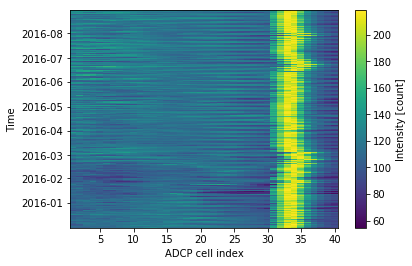

In [17]:
nct['INTENSITY'].plot()

# TESTING/OLD

In [ ]:
#ncfile = dpath + 'JASADCP/ncfiles/01305_short.nc'
#ncfile = dpath + 'JASADCP/ncfiles/00200_short.nc'
ncfile = dpath + 'JASADCP/ncfiles/02000_short.nc'
ncj = xr.open_dataset(ncfile)
ncj.attrs['cruise_sonar_summary'].split('\n')
string = ncj.attrs['cruise_sonar_summary']

# USE THIS ONE!!!
# hardware_model, serial_numbers, transmit_frequency, phased_array,
# cruise_beg_date, blanking_interval, bin_length, transducer_beam_angle,
# transmit_pulse_length, ...C (from Mullison 2017 Table 2),
# transmit_power (from Mullison 2017 Table 2)??
hardware_model = re.findall("HARDWARE MODEL *: *((?:\w+ )*\w+)", string)
blanking_interval = re.findall("BLANKING INTERVAL *: *((?:\w+ )*\w+)", string)
phased_array = re.findall("(phased array)", string, re.IGNORECASE)[0]
cruise_beg_date = ncj.time[0]
# \w = [A-Za-z0-9]

In [ ]:
print(df[df['phased_array']=='phased array']['hardware_model'].to_string())

In [48]:
fnames = []
for fname in os.listdir(dpath + 'JASADCP/ncfiles/'):
    if fname.endswith('.nc'):
        fnames.append(fname)

In [138]:
fnames[2236]

'01872_short.nc'

In [ ]:
[i for i,x in enumerate(hardware_model) if not x]

In [41]:
# hardware_model troubleshooting
# 5, 10, 11
# 00573_short.nc - NB 150 (VM-150-18HP)
# 00139_short.nc - VM-150 
# 01305_short.nc - RD-VM150 Narrow band 
# 43
# 00726_short.nc - blank with name under MANUFACTURER 

In [139]:
ncfile = dpath + 'JASADCP/ncfiles/01872_short.nc'
ncj = xr.open_dataset(ncfile)
ncj.attrs['cruise_sonar_summary'].split('\n')

[' #DATA_DATES: 2011/11/06 14:25:00 --- to --- 2011/12/11 09:26:00',
 ' #LON_RANGE:  70.88 W --- to ---  23.37 W',
 ' #LAT_RANGE:  14.88 N --- to ---  41.48 N',
 ' #DEPTH_RANGE:     22 --- to --- 654 m',
 ' #SAC_CRUISE_ID: 01872 ',
 ' #PLATFORM_NAME: R/V Knorr',
 ' #PRINCIPAL_INVESTIGATOR_NAME: E.Boyle,J.Hummon',
 ' #PI_INSTITUTION: MIT; University of Hawaii',
 ' #PI_COUNTRY: USA',
 ' #PROJECT: GEOTRACES ',
 ' #CRUISE_NAME: kn204_01:os75bb',
 ' #PORTS: Woods Hole, Massachusetts;',
 '         Praia, Cape Verde Islands',
 ' #GEOGRAPHIC_REGION:  north Atlantic',
 ' #PROCESSED_BY: University of Hawaii at Manoa',
 ' #NAVIGATION: GPS                          ',
 ' #QUALITY_NAV: <excellent> ',
 ' #GENERAL_INFORMATION: ',
 'CRUISE NOTES',
 '  CHIEF SCIENTIST ON SHIP     : Edward Boyle',
 '    INSTITUTE                 : MIT',
 '    COUNTRY                   : USA',
 '  SIGNIFICANT DATA GAPS       : ',
 '  SPECIAL SHIP TRACK PATTERNS :',
 '  COMMENTS                    : ',
 'This cruise has tw